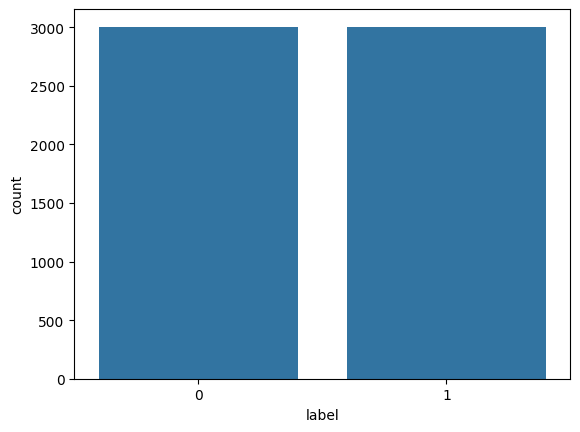

,text,label
7721,I believe it is a neat idea to have technology...,0
16951,"Dear Senator,\n\nI am writing to you today to ...",1
16250,"In recent years, there has been a growing move...",1
1373,There has been a fuss about the Elector Colleg...,0
1795,The Importance of Keeping the Electoral Colleg...,1


In [2]:
import pandas as pd 
import numpy as np 
import re
import torch
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification,AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader,TensorDataset

logging.basicConfig(level=logging.ERROR)
#balance training dataset
df = pd.read_csv('/Users/chenyufeng/desktop/dataset/Additional_training_essays.csv')

dataset_0= df[df['label'] == 0]
dataset_1= df[df['label'] == 1]
dataset_0 = dataset_0.sample(n=3004, random_state=42)

df = pd.concat([dataset_0, dataset_1])
df = df.sample(frac=1, random_state=42)

sns.countplot(data=df, x='label')
plt.show()

df.head()

In [3]:
# remove punctuation, clean the raw text data

def text_processing(text):
    text = re.sub(r'[^\w\s]', '', text) 
    words = text.split()
    words = [word.lower() for word in words if word.isalpha()]
    return ' '.join(words)

df['new_text'] = df['text'].apply(text_processing)

df.head()


,text,label,new_text
7721,I believe it is a neat idea to have technology...,0,i believe it is a neat idea to have technology...
16951,"Dear Senator,\n\nI am writing to you today to ...",1,dear senator i am writing to you today to expr...
16250,"In recent years, there has been a growing move...",1,in recent years there has been a growing movem...
1373,There has been a fuss about the Elector Colleg...,0,there has been a fuss about the elector colleg...
1795,The Importance of Keeping the Electoral Colleg...,1,the importance of keeping the electoral colleg...


In [4]:
#create training and testing dataset 

x_train, x_test, y_train, y_test = train_test_split(df['new_text'], df['label'], test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding=True, truncation=True, max_length=512)

train_tokens=tokenizer(x_train.tolist(), padding=True, truncation=True, return_tensors='pt')
test_tokens = tokenizer(x_test.tolist(), padding=True, truncation=True, return_tensors='pt')

train_labels = torch.tensor(y_train.values)
test_labels = torch.tensor(y_test.values)

train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], train_labels)
test_dataset = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [6]:
#fine tune bert


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)

epochs = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * total_steps, num_training_steps=total_steps)

checkpoint_dir = "/Users/chenyufeng/desktop/project_2"

def find_latest_checkpoint(checkpoint_dir):
    checkpoint_files = [file for file in os.listdir(checkpoint_dir) if file.endswith('.pt')]
    if checkpoint_files:
        valid_files = [f for f in checkpoint_files if 'model_epoch_' in f]
        if not valid_files:
            return None

        valid_files.sort(key=lambda f: int(f.split('_')[-1].replace('.pt', '')))
        latest_checkpoint = valid_files[-1]

        return os.path.join(checkpoint_dir, latest_checkpoint)
    
    return None


latest_checkpoint = find_latest_checkpoint(checkpoint_dir)
start_epoch = 0
if latest_checkpoint:
    print(f"Resuming training from checkpoint: {latest_checkpoint}")
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']

model.train()
for epoch in range(start_epoch, epochs):
    total_loss = 0

    for batch in tqdm(train_loader):
        input_ids, attention_mask,labels = batch 
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids,attention_mask=attention_mask,labels=labels)

        loss = outputs.loss
        total_loss+=loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        optimizer.step()
        scheduler.step()
    
    model_save_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch + 1}.pt")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, model_save_path)
    print(f"Model saved to {model_save_path}")

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Resuming training from checkpoint: /Users/chenyufeng/desktop/project_2/model_epoch_4.pt


100%|██████████| 4806/4806 [19:01<00:00,  4.21it/s]


Model saved to /Users/chenyufeng/desktop/project_2/model_epoch_5.pt
Epoch 5/5, Average Training Loss: 0.0000


100%|██████████| 1202/1202 [01:01<00:00, 19.57it/s]


Test Accuracy: 0.9983


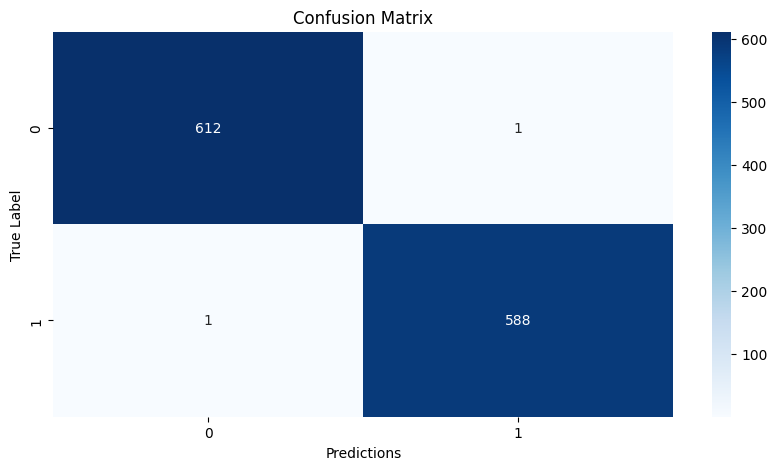

In [7]:
#test the fine-tuned bert 

model.eval()
preds=[]
vals=[]

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        vals.extend(labels.cpu().numpy())


    accuracy = accuracy_score(vals, preds)
    print(f"Test Accuracy: {accuracy:.4f}")
    matrix = confusion_matrix(vals, preds)

    plt.figure(figsize=(10, 5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predictions')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
